<a href="https://colab.research.google.com/github/Tar-ive/stock-quants/blob/main/quant_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 14.8 MB/s eta 0:00:00


In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=b279eb1426b4937cdf42f7c8d7a5c4c098ebb046d2a732ae5e4a84d72afd604e
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [5]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [6]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

In [7]:
symbols_list = sp500['Symbol'].unique().tolist()

In [8]:
end_date = '2024-06-21'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

In [9]:
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

[*********************100%%**********************]  503 of 503 completed


In [10]:
df.index.names = ['date', 'ticker']

In [11]:
df.columns = df.columns.str.lower()

In [12]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-23 A        43.803680   46.680000   46.680000   46.389999   46.500000   
           AAL      29.147837   30.330000   30.490000   29.770000   30.250000   
           AAPL     22.066637   24.025000   24.072500   23.812500   23.985001   
           ABBV     43.449436   61.310001   61.320000   60.619999   60.860001   
           ABT      34.204819   39.630001   39.630001   38.990002   39.040001   
...                       ...         ...         ...         ...         ...   
2024-06-20 XYL     139.229996  139.229996  140.369995  138.850006  140.000000   
           YUM     134.149994  134.149994  135.720001  134.020004  134.679993   
           ZBH     106.250000  106.250000  106.809998  105.379997  105.570000   
           ZBRA    296.640015  296.640015  298.269989  295.049988  296.000000   
           ZTS     168.179993  168.179993  171.100006  167.100006  169.820007   

Price                   volume  
date       ticker               
2016-06-23 A         1487900.0  
           AAL       9139900.0  
           AAPL    128960800.0  
           ABBV      5328200.0  
           ABT      10755500.0  
...                        ...  
2024-06-20 XYL        973300.0  
           YUM       3170900.0  
           ZBH       1887600.0  
           ZBRA       352300.0  
           ZTS       3233700.0  

[991659 rows x 6 columns]

In [13]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


In [14]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

In [15]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [16]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [17]:
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [18]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

In [19]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-06-23 A        43.803680   46.680000   46.680000   46.389999   46.500000   
           AAL      29.147837   30.330000   30.490000   29.770000   30.250000   
           AAPL     22.066637   24.025000   24.072500   23.812500   23.985001   
           ABBV     43.449436   61.310001   61.320000   60.619999   60.860001   
           ABT      34.204819   39.630001   39.630001   38.990002   39.040001   
...                       ...         ...         ...         ...         ...   
2024-06-20 XYL     139.229996  139.229996  140.369995  138.850006  140.000000   
           YUM     134.149994  134.149994  135.720001  134.020004  134.679993   
           ZBH     106.250000  106.250000  106.809998  105.379997  105.570000   
           ZBRA    296.640015  296.640015  298.269989  295.049988  296.000000   
           ZTS     168.179993  168.179993  171.100006  167.100006  169.820007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-06-23 A         1487900.0         -0.001359        NaN       NaN   
           AAL       9139900.0         -0.000247        NaN       NaN   
           AAPL    128960800.0         -0.002625        NaN       NaN   
           ABBV      5328200.0         -0.043800        NaN       NaN   
           ABT      10755500.0         -0.006621        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-20 XYL        973300.0          0.000048  52.441343  4.916945   
           YUM       3170900.0          0.000073  42.357229  4.901702   
           ZBH       1887600.0          0.000075  25.267026  4.658673   
           ZBRA       352300.0          0.000057  43.793518  5.674165   
           ZTS       3233700.0          0.000243  46.214182  5.120088   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-06-23 A            NaN       NaN       NaN       NaN      65.175496  
           AAL          NaN       NaN       NaN       NaN     266.408313  
           AAPL         NaN       NaN       NaN       NaN    2845.731166  
           ABBV         NaN       NaN       NaN       NaN     231.507286  
           ABT          NaN       NaN       NaN       NaN     367.889928  
...                     ...       ...       ...       ...            ...  
2024-06-20 XYL     4.947188  4.977431  0.800363  0.029525     135.512555  
           YUM     4.931069  4.960436  0.375948 -0.557297     425.376216  
           ZBH     4.727787  4.796902 -0.674481 -1.456890     200.557500  
           ZBRA    5.737598  5.801030 -0.199512 -0.524278     104.506277  
           ZTS     5.156507  5.192926  0.550648  0.109882     543.843642  

[991659 rows x 14 columns]

In [20]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

In [21]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

In [22]:
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A           75.466181   45.264523 -1.323639  3.843352  3.746726   
           AAL        401.105358   34.116322  0.730211  3.684955  3.334677   
           AAPL      3118.136091   23.928873 -1.232185  3.213437  3.110997   
           ABBV       350.139813   47.348209 -1.370464  3.873788  3.809447   
           ABT        403.487967   38.861832 -1.213903  3.695173  3.562258   
...                          ...         ...       ...       ...       ...   
2024-06-30 XYL        149.916829  139.229996  0.800363  4.977431  4.916945   
           YUM        252.833912  134.149994  0.375948  4.960436  4.901702   
           ZBH        179.009809  106.250000 -0.674481  4.796902  4.658673   
           ZBRA        77.539871  296.640015 -0.199512  5.801030  5.674165   
           ZTS        375.169089  168.179993  0.550648  5.192926  5.120088   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-07-31 A       3.795039         -0.000743  0.396989  63.811826  
           AAL     3.509816         -0.000845  3.409533  62.237642  
           AAPL    3.162217         -0.002745  0.007282  70.870767  
           ABBV    3.841618         -0.039624  0.305417  71.470081  
           ABT     3.628716         -0.006625  1.079761  79.278135  
...                     ...               ...       ...        ...  
2024-06-30 XYL     4.947188          0.000048  0.029525  52.441343  
           YUM     4.931069          0.000073 -0.557297  42.357229  
           ZBH     4.727787          0.000075 -1.456890  25.267026  
           ZBRA    5.737598          0.000057 -0.524278  43.793518  
           ZTS     5.156507          0.000243  0.109882  46.214182  

[47328 rows x 9 columns]

In [23]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

In [24]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

In [25]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [26]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-06-30 AAL      48.838978  0.521162  3.923412  3.858654  3.891033   
           AAPL     33.703407 -1.102909  3.619503  3.515703  3.567603   
           ABBV     53.369358 -1.542864  4.020166  3.924985  3.972575   
           ABT      43.018211 -1.347966  3.809783  3.734658  3.772221   
           ACN     111.341927 -1.110384  4.766373  4.703720  4.735047   
...                       ...       ...       ...       ...       ...   
2024-06-30 VZ       40.240002 -0.640573  3.754687  3.684036  3.719362   
           WFC      58.959999 -0.111734  4.123838  4.054981  4.089410   
           WMT      68.010002  0.948926  4.237457  4.179719  4.208588   
           XOM     111.739998  0.639364  4.771997  4.694687  4.733342   
           ZTS     168.179993  0.550648  5.192926  5.120088  5.156507   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-06-30 AAL            -0.000020  0.701130  59.919048  
           AAPL           -0.001808 -0.461999  43.606743  
           ABBV           -0.036447  0.403627  71.505938  
           ABT            -0.006063  0.473638  67.057067  
           ACN            -0.003969 -0.190611  49.971664  
...                             ...       ...        ...  
2024-06-30 VZ              0.000097 -0.059704  50.928993  
           WFC             0.000048 -0.525382  51.094303  
           WMT             0.000038  2.388943  70.046153  
           XOM             0.000267 -1.460914  45.614285  
           ZTS             0.000243  0.109882  46.214182  

[12665 rows x 8 columns]

In [27]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156166  0.686495  3.838545  3.636104  3.737324   
           AAPL     43.992630 -1.043094  3.861789  3.786773  3.824281   
           ABBV     70.505768 -0.296695  4.376233  4.251017  4.313625   
           ABT      55.062874 -0.974494  4.076934  4.017404  4.047169   
           ACN     150.009079 -0.645898  5.034309  4.970734  5.002521   
...                       ...       ...       ...       ...       ...   
2024-06-30 VRTX    471.380005  1.190999  6.213020  6.085279  6.149150   
           VZ       40.240002 -0.640573  3.754687  3.684036  3.719362   
           WFC      58.959999 -0.111734  4.123838  4.054981  4.089410   
           WMT      68.010002  0.948926  4.237457  4.179719  4.208588   
           XOM     111.739998  0.639364  4.771997  4.694687  4.733342   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -0.000030 -1.708985  30.484801  -0.128158   
           AAPL           -0.000987 -0.330627  49.582361  -0.009418   
           ABBV           -0.029046 -1.209509  38.080583  -0.063574   
           ABT            -0.004588 -0.317932  47.018531  -0.008776   
           ACN            -0.003033  0.039801  58.053363   0.050404   
...                             ...       ...        ...        ...   
2024-06-30 VRTX            0.000183  2.507502  61.673207   0.035226   
           VZ              0.000097 -0.059704  50.928993  -0.022114   
           WFC             0.000048 -0.525382  51.094303  -0.016021   
           WMT             0.000038  2.388943  70.046153   0.034215   
           XOM             0.000267 -1.460914  45.614285  -0.047075   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007380    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040165   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-06-30 VRTX     0.095454   0.040866   0.024823   0.034379    0.024656  
           VZ       0.009451  -0.008560   0.016465   0.030417    0.012618  
           WFC     -0.000177   0.007642   0.032740   0.044090    0.029813  
           WMT      0.072325   0.042872   0.045112   0.028635    0.023180  
           XOM     -0.024059  -0.010410   0.021655  -0.002719    0.006322  

[10510 rows x 14 columns]

In [28]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10226 rows x 6 columns]

In [29]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.043625
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[10182 rows x 6 columns]

In [30]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.445515 -1.035399  0.572178  0.109528 -0.072875
           WFC     1.099293  0.259485  1.225701 -0.520461 -0.781068
           WMT     0.609516  0.128328 -0.665654  0.617154  0.467717
           XOM     0.792347 -0.105847  0.684729  0.876951  0.323338

[10182 rows x 5 columns]

In [31]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10326 entries, (Timestamp('2018-06-30 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10326 non-null  float64
 1   bb_high           10326 non-null  float64
 2   bb_low            10326 non-null  float64
 3   bb_mid            10326 non-null  float64
 4   garman_klass_vol  10326 non-null  float64
 5   macd              10326 non-null  float64
 6   rsi               10326 non-null  float64
 7   return_1m         10326 non-null  float64
 8   return_2m         10326 non-null  float64
 9   return_3m         10326 non-null  float64
 10  return_6m         10326 non-null  float64
 11  return_9m         10326 non-null  float64
 12  return_12m        10326 non-null  float64
 13  Mkt-RF            10326 non-null  float64
 14  SMB               10326 non-null  float64
 15  HML        

In [32]:
from sklearn.cluster import KMeans



def get_clusters(df, initial_centroids=None):
    # Define the KMeans model
    if initial_centroids is not None:
        kmeans = KMeans(n_clusters=4, init=initial_centroids, random_state=0)
    else:
        kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)

    # Fit the model
    df['cluster'] = kmeans.fit_predict(df)
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 AAL     0.686495  3.838545  3.636104  3.737324         -0.000030   
           AAPL   -1.043094  3.861789  3.786773  3.824281         -0.000987   
           ABBV   -0.296695  4.376233  4.251017  4.313625         -0.029046   
           ABT    -0.974494  4.076934  4.017404  4.047169         -0.004588   
           ACN    -0.645898  5.034309  4.970734  5.002521         -0.003033   
...                     ...       ...       ...       ...               ...   
2024-06-30 VRTX    1.190999  6.213020  6.085279  6.149150          0.000183   
           VZ     -0.640573  3.754687  3.684036  3.719362          0.000097   
           WFC    -0.111734  4.123838  4.054981  4.089410          0.000048   
           WMT     0.948926  4.237457  4.179719  4.208588          0.000038   
           XOM     0.639364  4.771997  4.694687  4.733342          0.000267   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 AAL    -1.708985  30.484801  -0.128158  -0.058566  -0.098656   
           AAPL   -0.330627  49.582361  -0.009418   0.060393   0.034635   
           ABBV   -1.209509  38.080583  -0.063574  -0.020405  -0.003677   
           ABT    -0.317932  47.018531  -0.008776   0.024305   0.007529   
           ACN     0.039801  58.053363   0.050404   0.040165   0.024443   
...                     ...        ...        ...        ...        ...   
2024-06-30 VRTX    2.507502  61.673207   0.035226   0.095454   0.040866   
           VZ     -0.059704  50.928993  -0.022114   0.009451  -0.008560   
           WFC    -0.525382  51.094303  -0.016021  -0.000177   0.007642   
           WMT     2.388943  70.046153   0.034215   0.072325   0.042872   
           XOM    -1.460914  45.614285  -0.047075  -0.024059  -0.010410   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.210478  1.477898   
           AAPL     0.016401   0.021872    0.022450  1.320042 -0.351308   
           ABBV    -0.004230   0.007380    0.023476  0.471375  0.528255   
           ABT      0.012748   0.016592    0.020784  0.794143 -0.140757   
           ACN      0.012599   0.023607    0.025152  1.215271 -0.186538   
...                      ...        ...         ...       ...       ...   
2024-06-30 VRTX     0.024823   0.034379    0.024656  0.512476  0.078849   
           VZ       0.016465   0.030417    0.012618  0.470874 -0.438122   
           WFC      0.032740   0.044090    0.029813  1.082111 -0.098573   
           WMT      0.045112   0.028635    0.023180  0.610216 -0.395168   
           XOM      0.021655  -0.002719    0.006322  1.080185  0.163247   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.439869  0.141818  0.818849        2  
           AAPL   -0.620519  0.440863  0.617825        3  
           ABBV   -0.198804  0.540743  0.439447        2  
           ABT    -0.447179  0.257292  0.939716        0  
           ACN    -0.260720  0.331248  0.100942        1  
...                     ...       ...       ...      ...  
2024-06-30 VRTX   -0.895770  0.061019  0.856762        1  
           VZ      0.209219  0.210804  0.255781        3  
           WFC     1.563894 -0.754983 -0.838410        3  
           WMT    -0.368600  0.229216  0.692202        1  
           XOM     0.820530 -0.478975  0.467466        3  

[10326 rows x 19 columns]

In [33]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

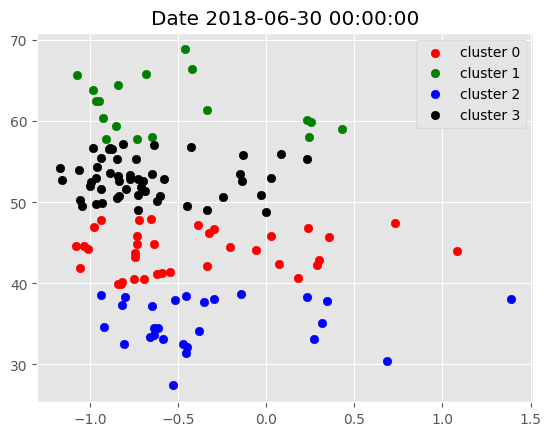

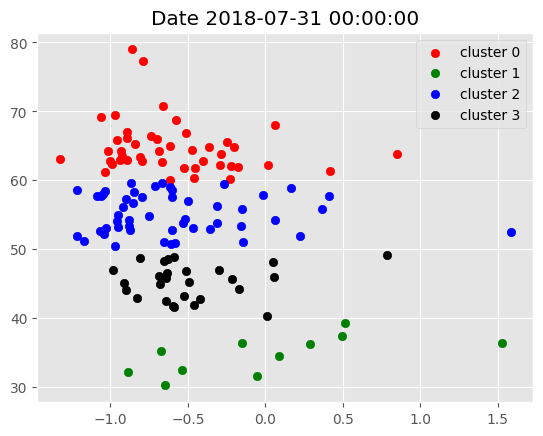

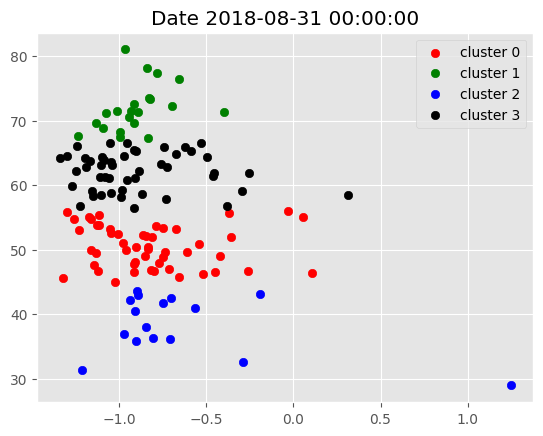

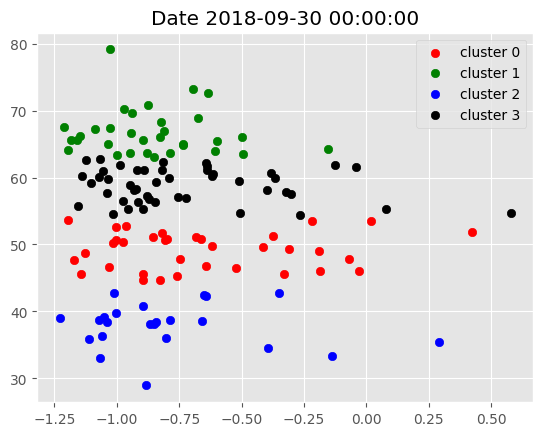

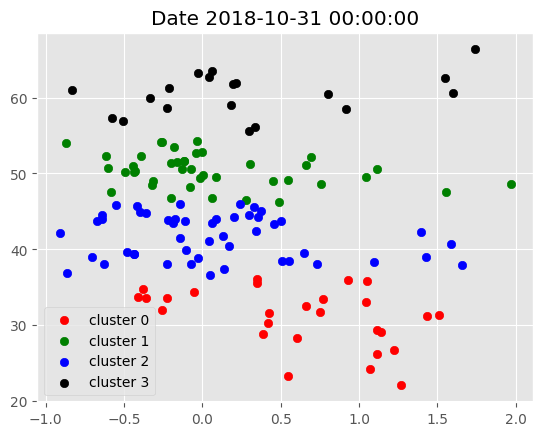

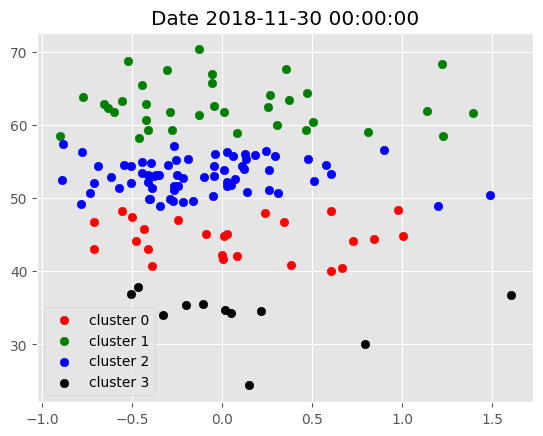

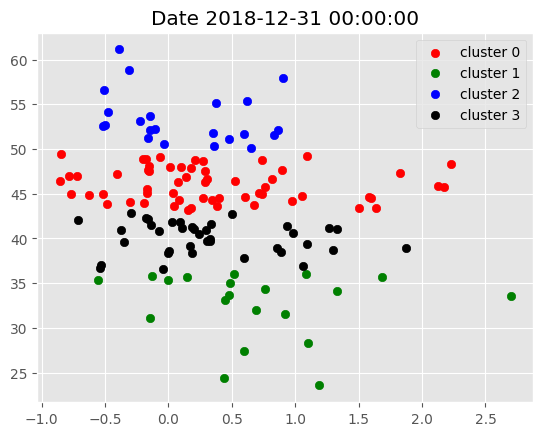

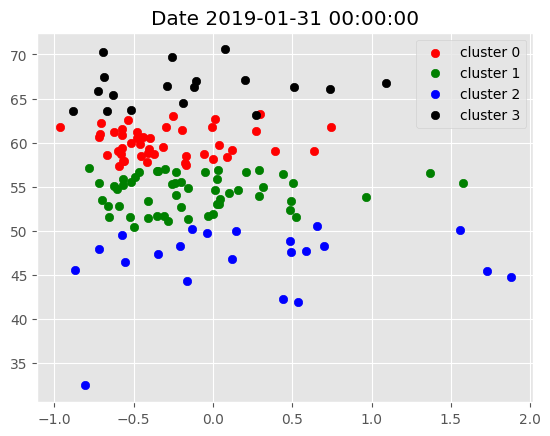

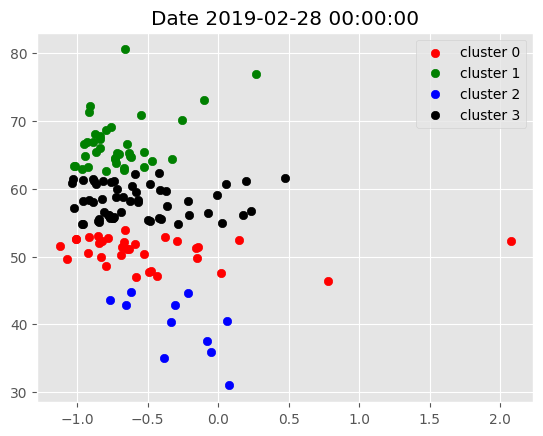

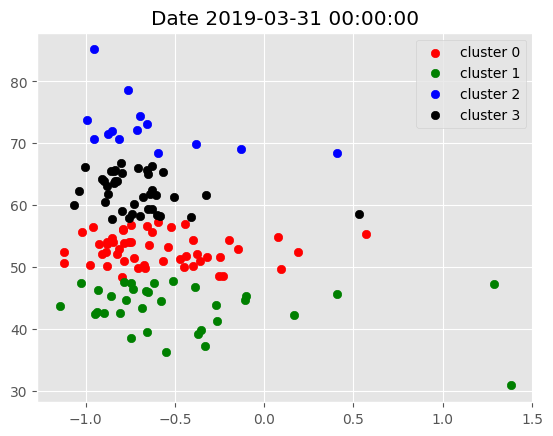

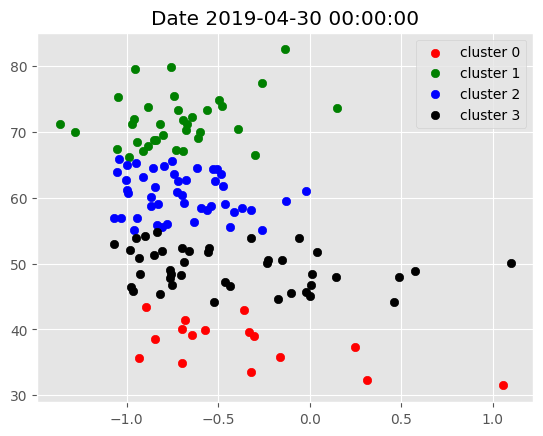

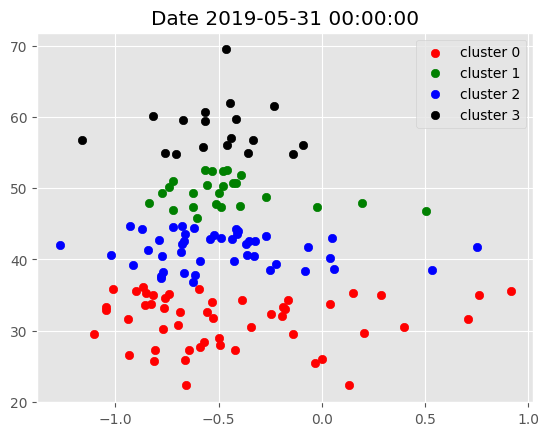

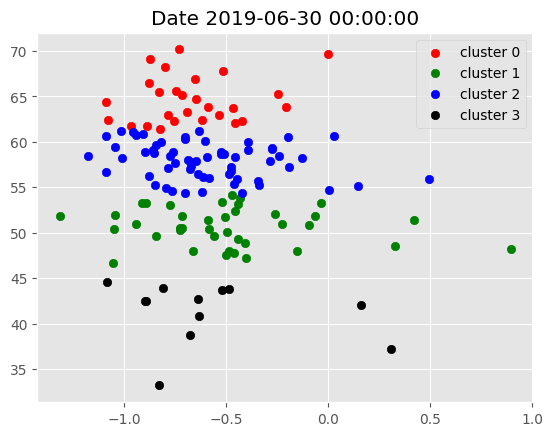

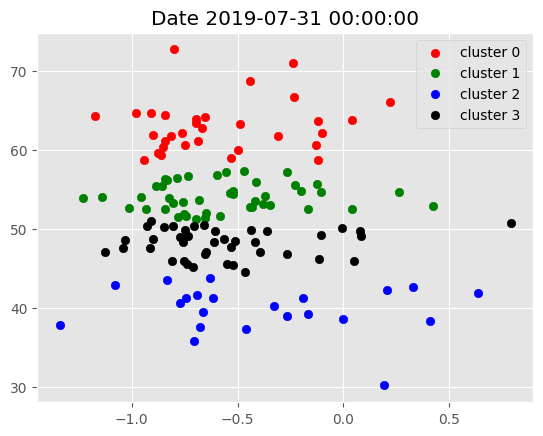

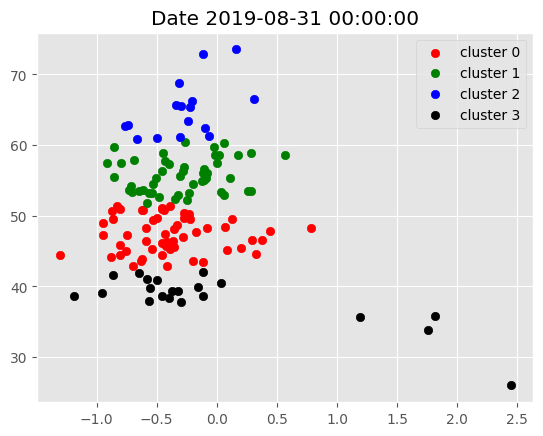

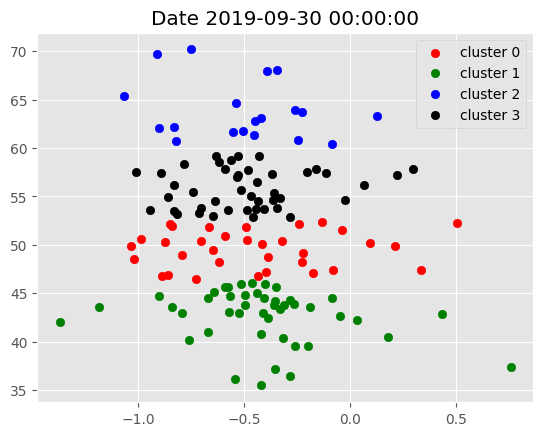

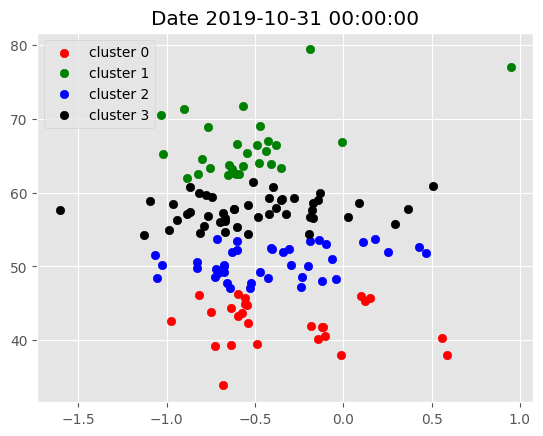

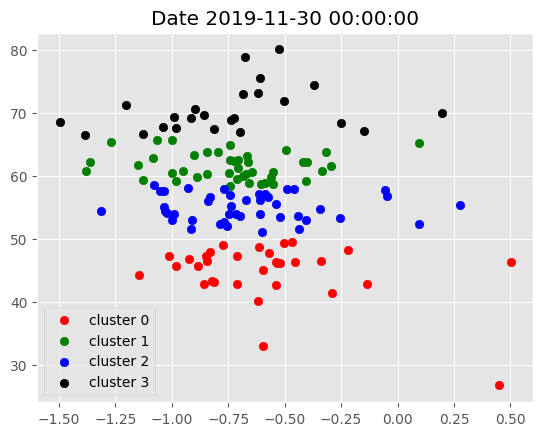

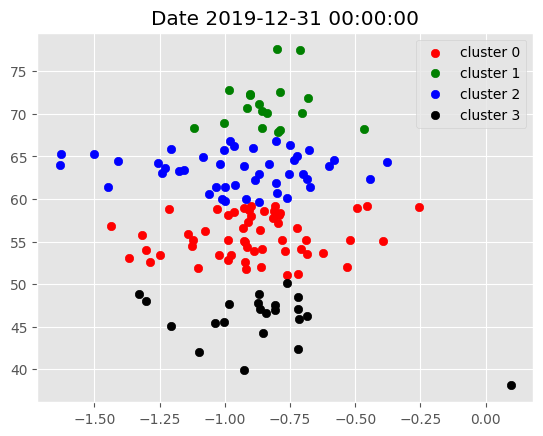

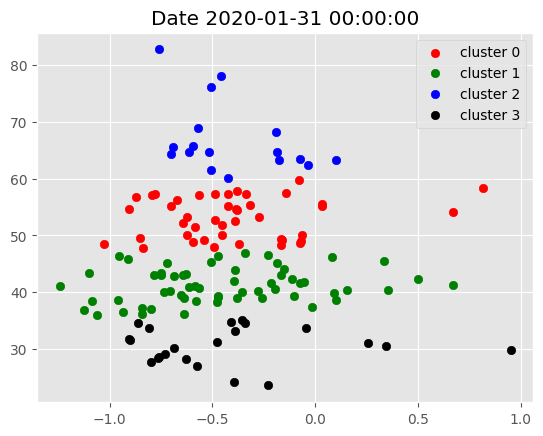

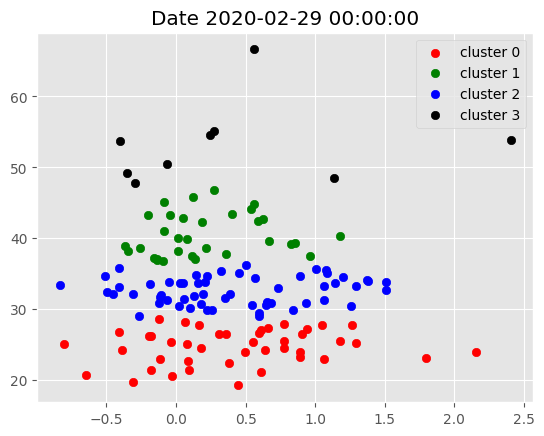

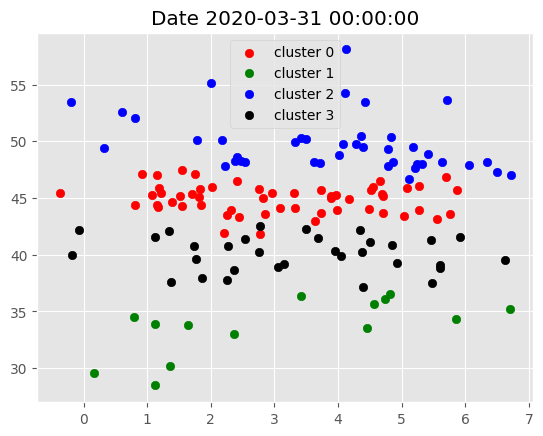

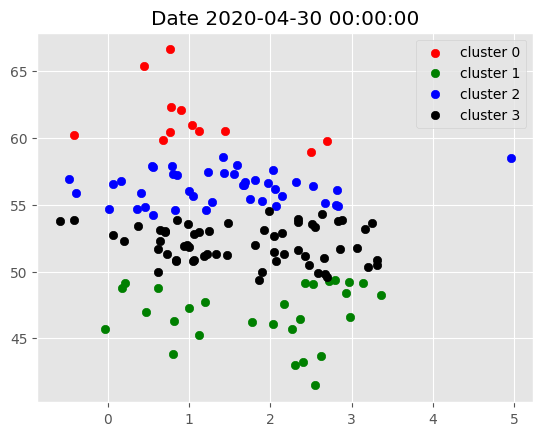

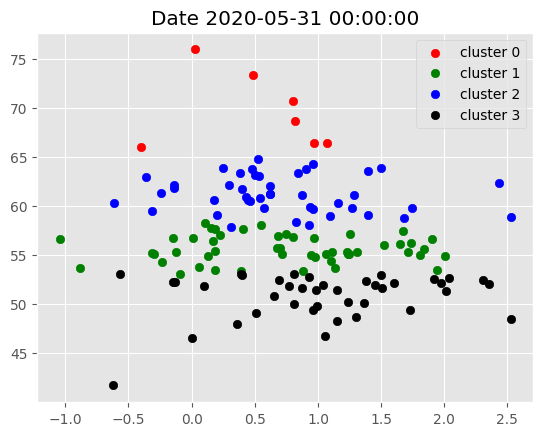

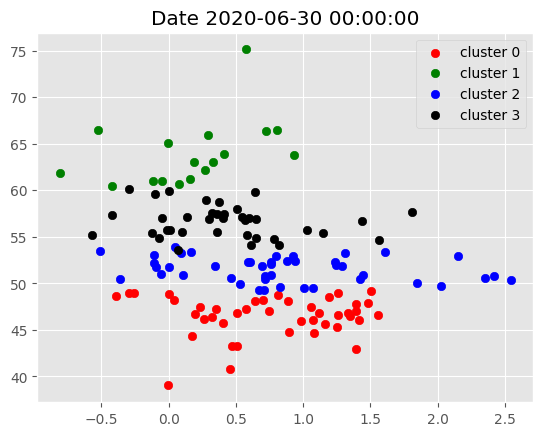

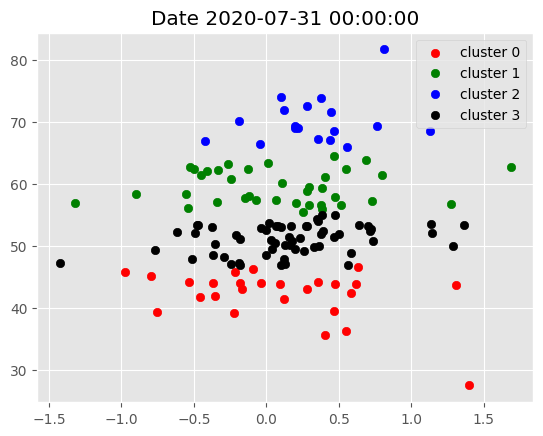

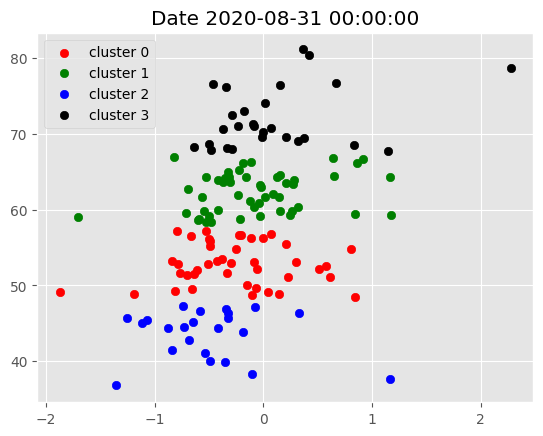

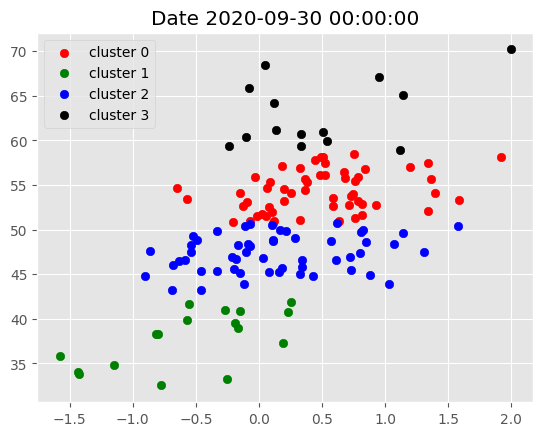

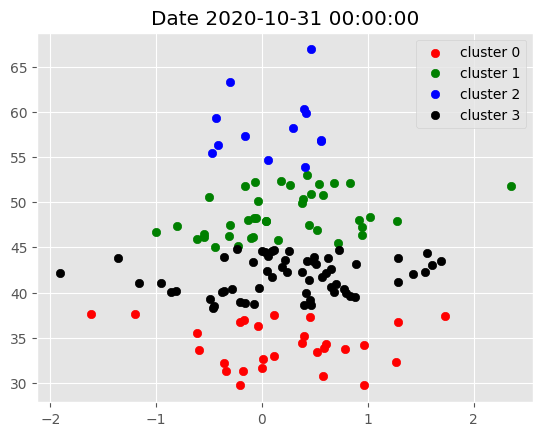

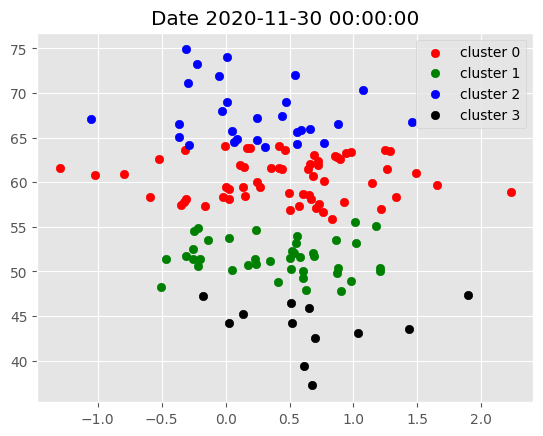

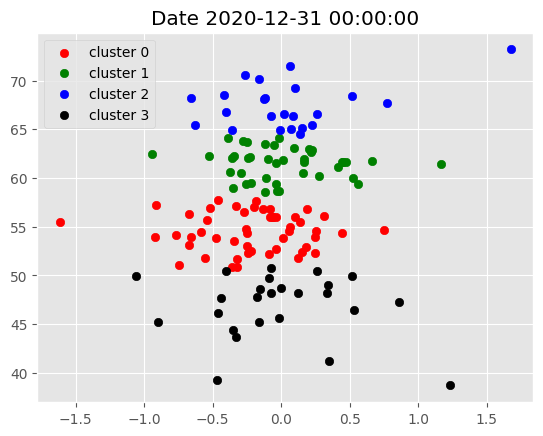

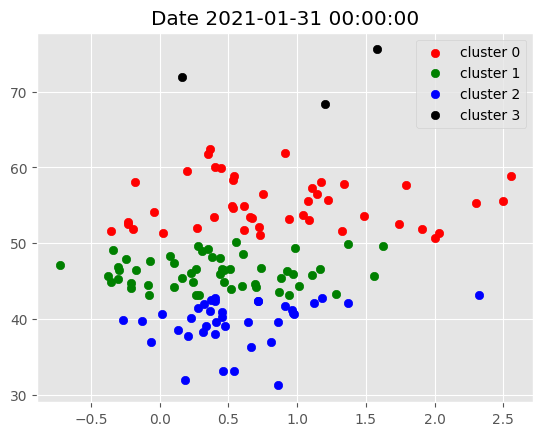

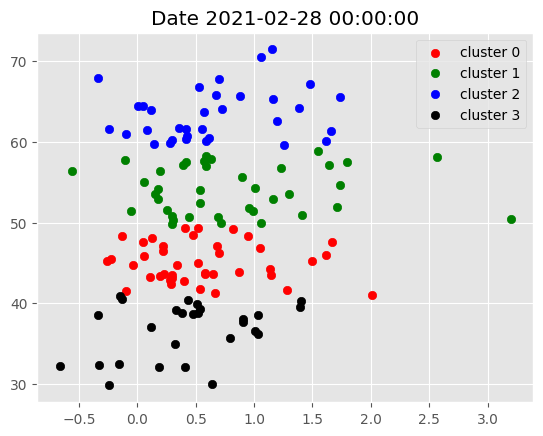

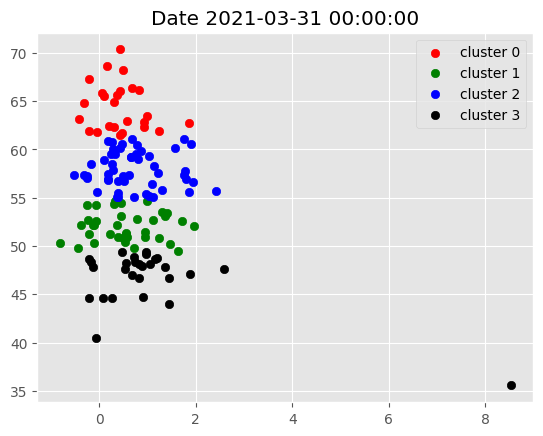

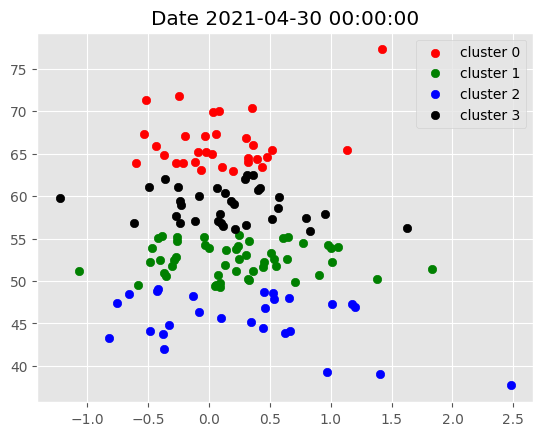

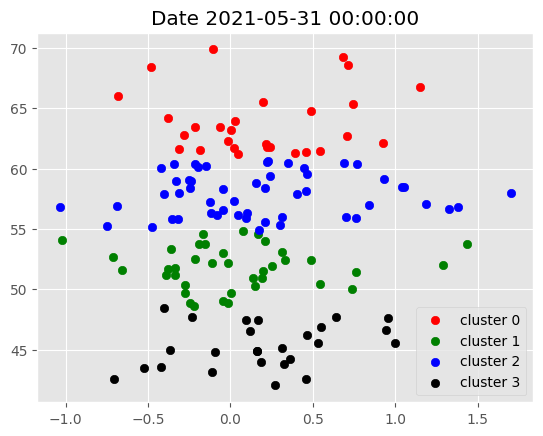

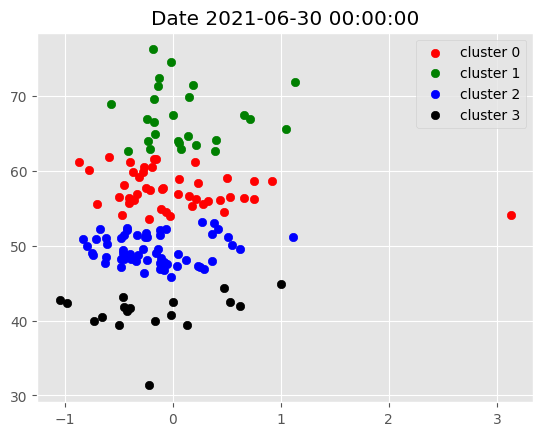

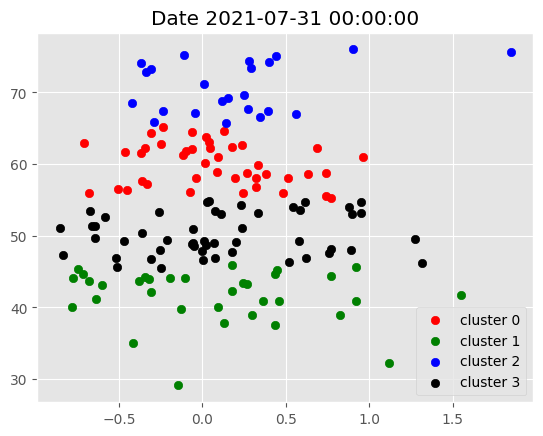

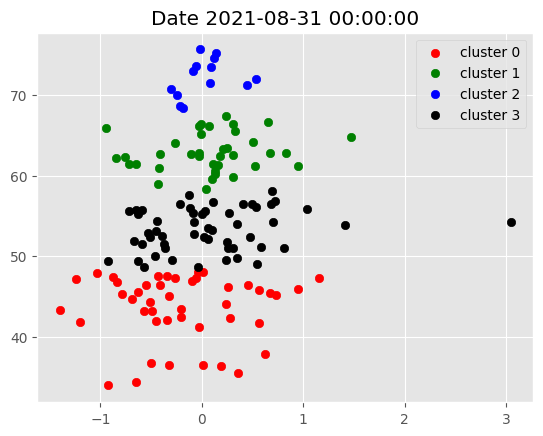

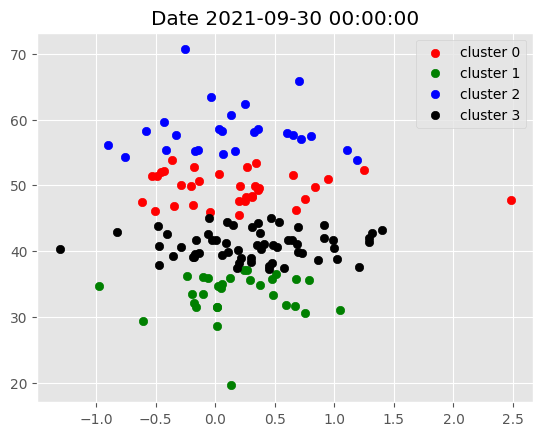

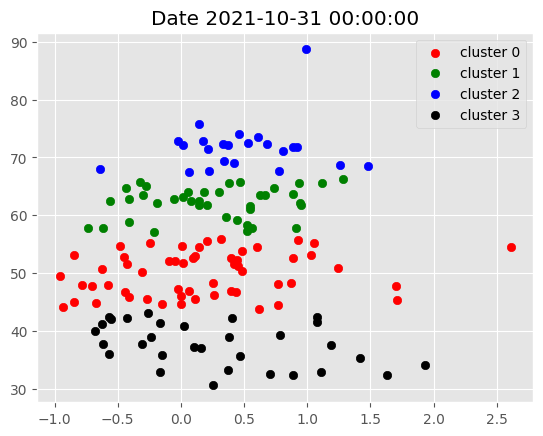

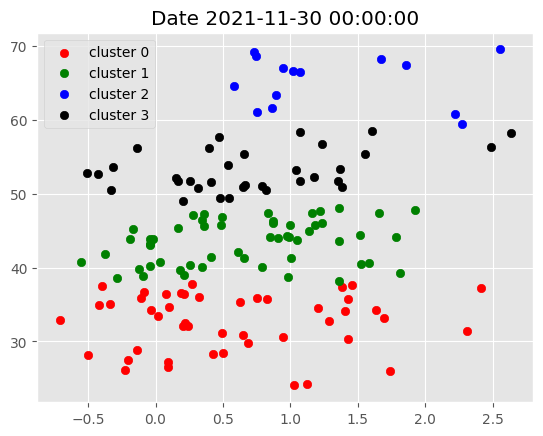

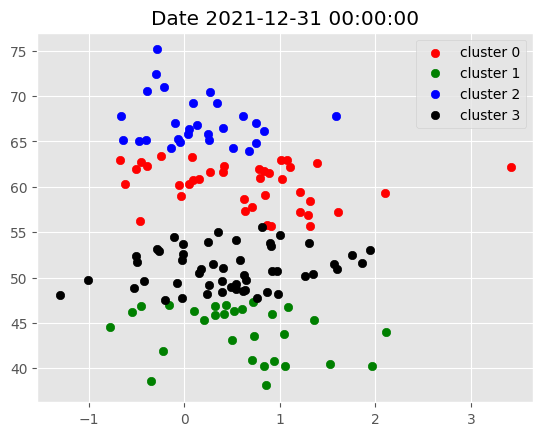

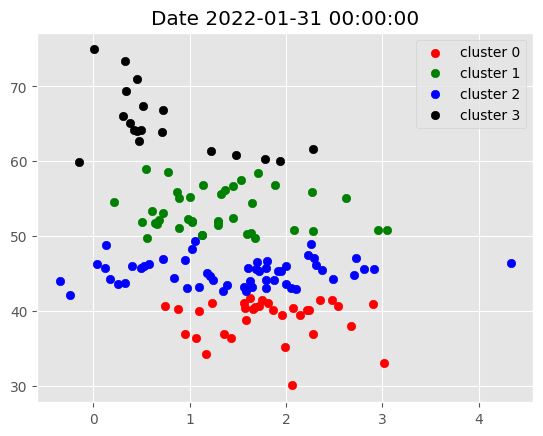

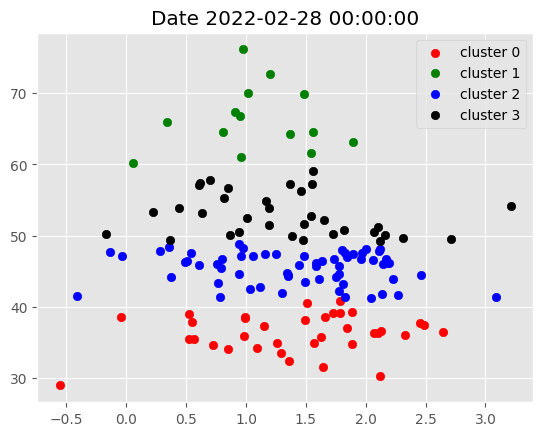

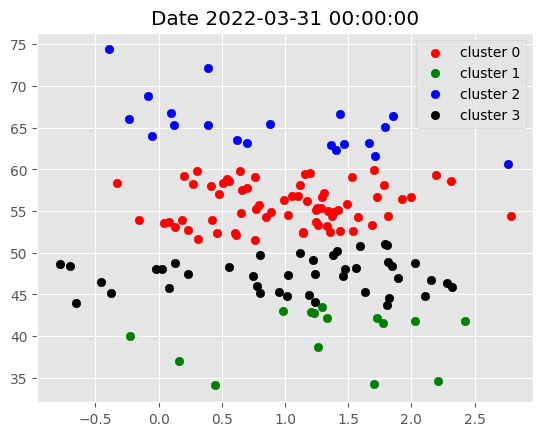

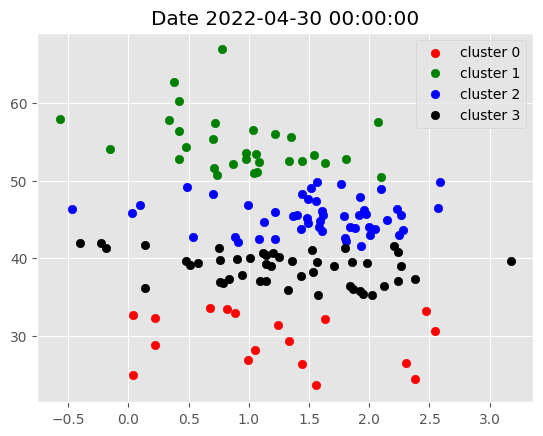

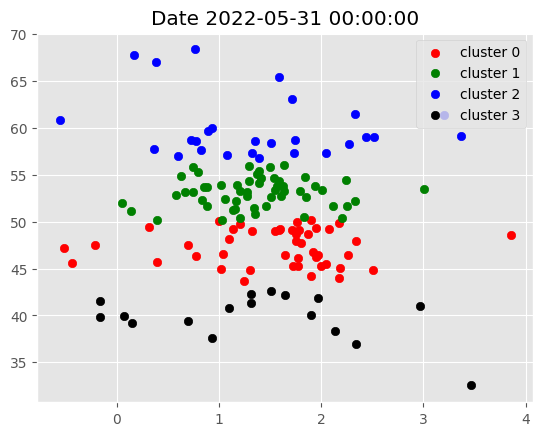

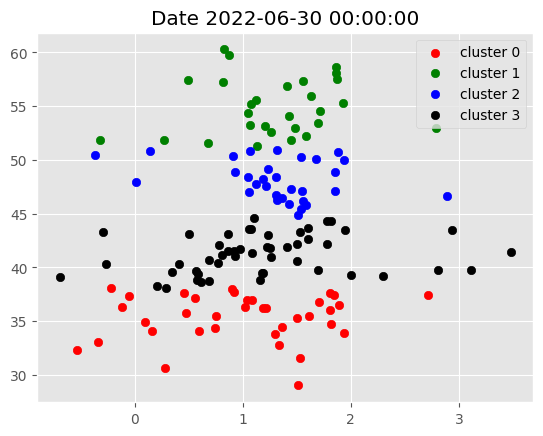

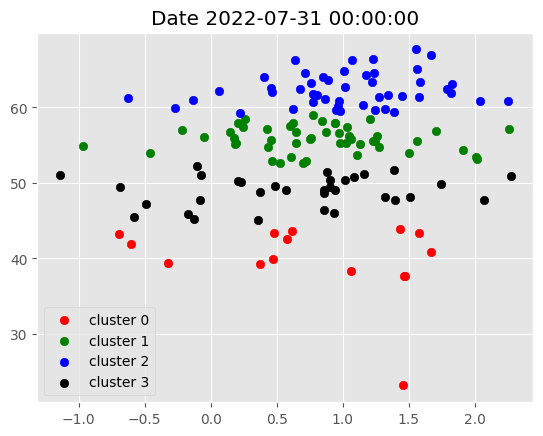

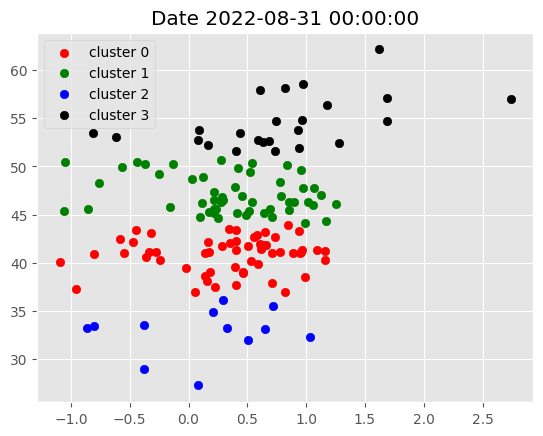

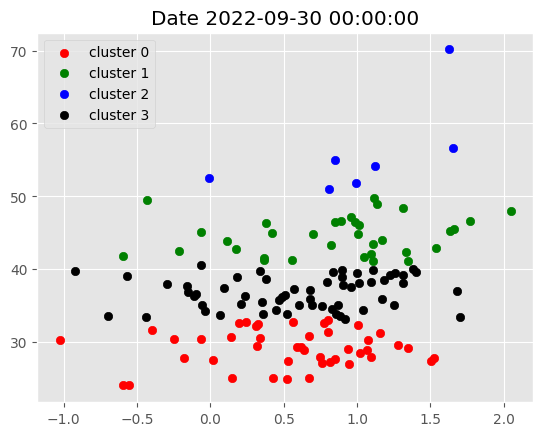

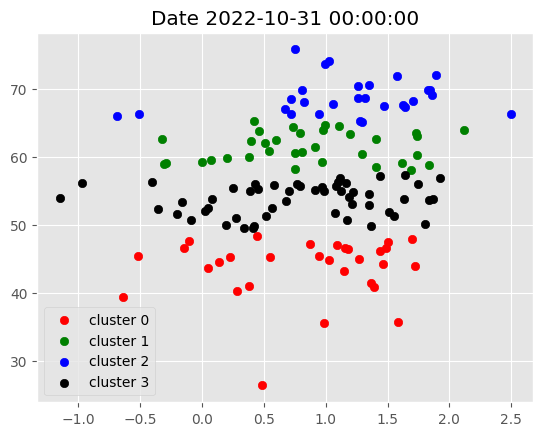

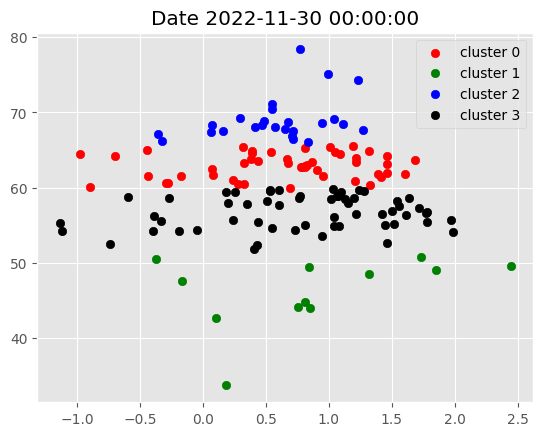

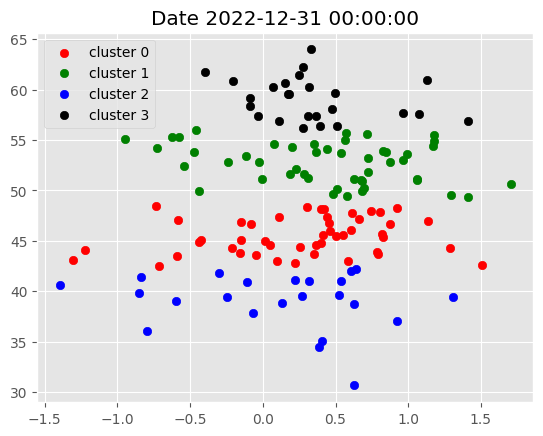

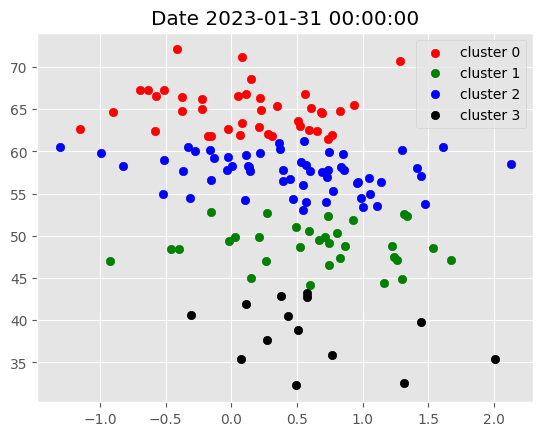

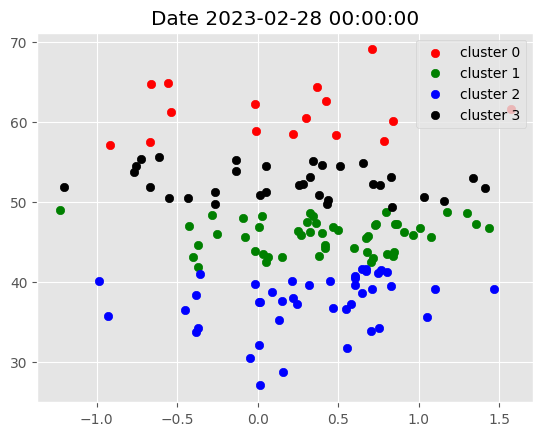

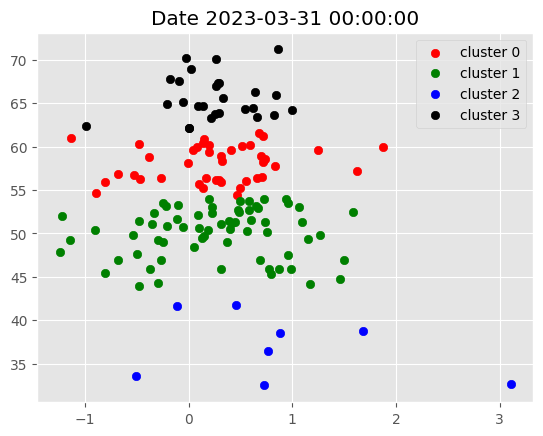

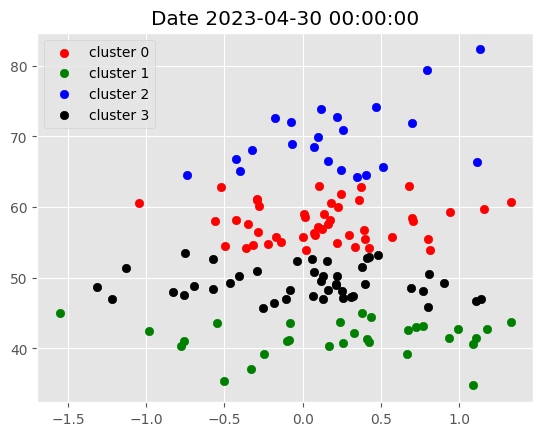

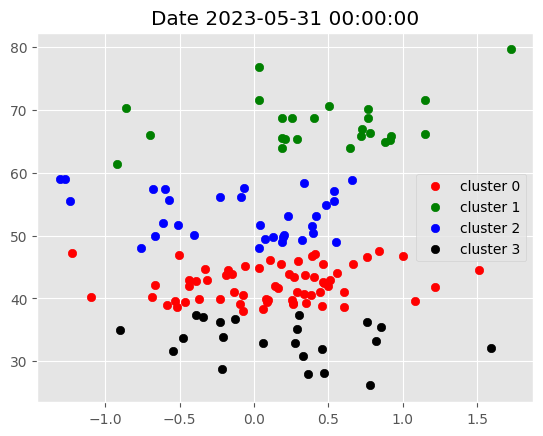

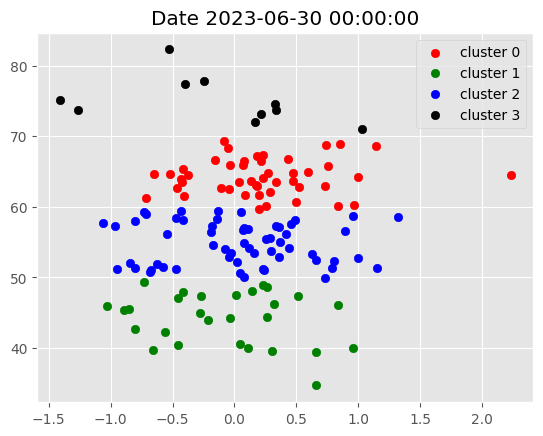

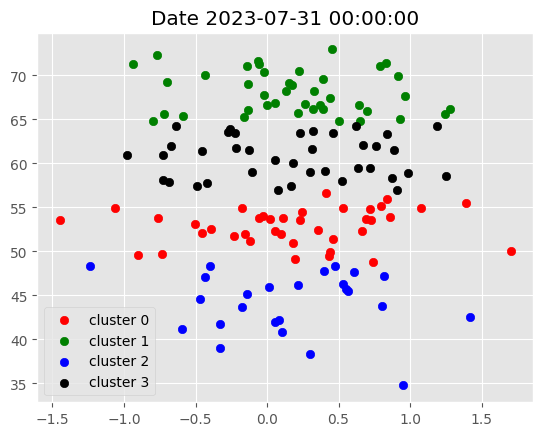

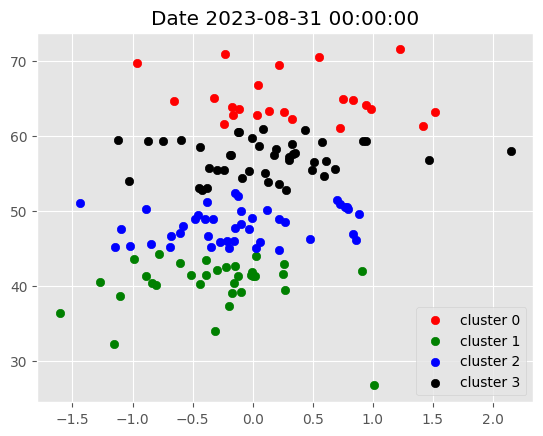

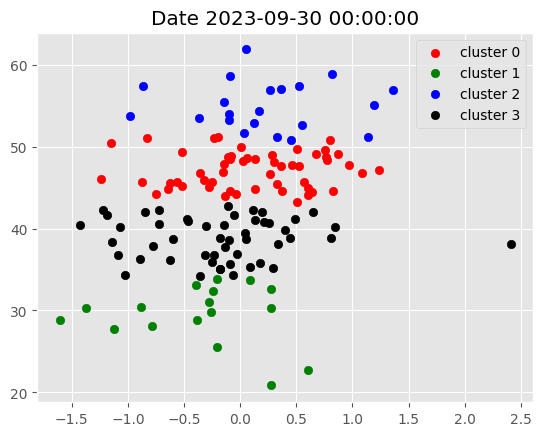

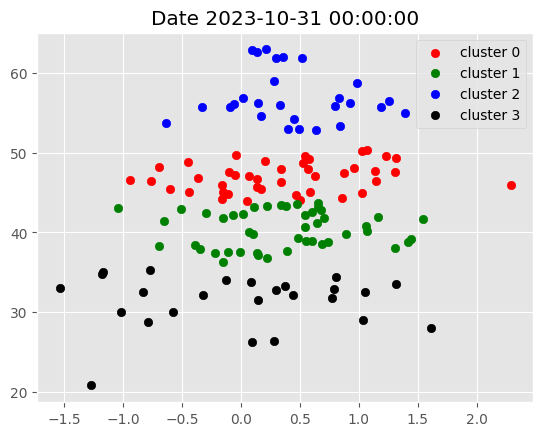

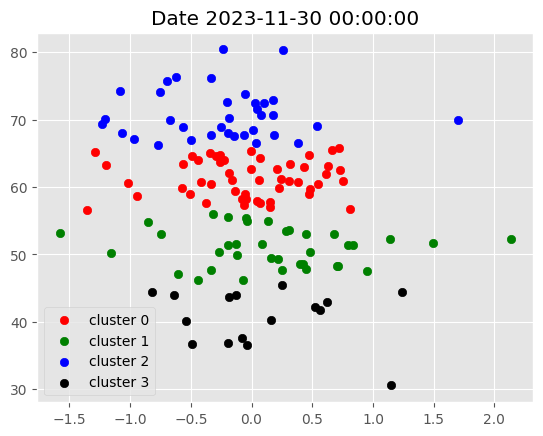

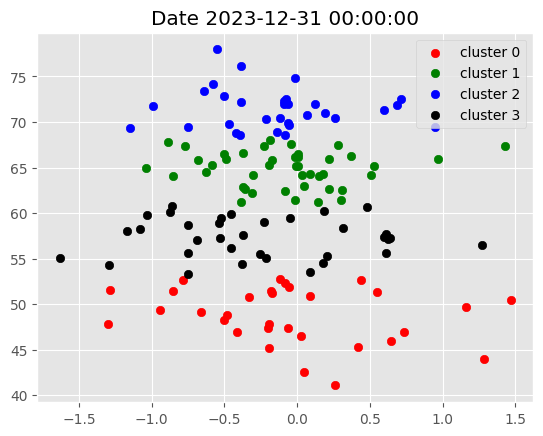

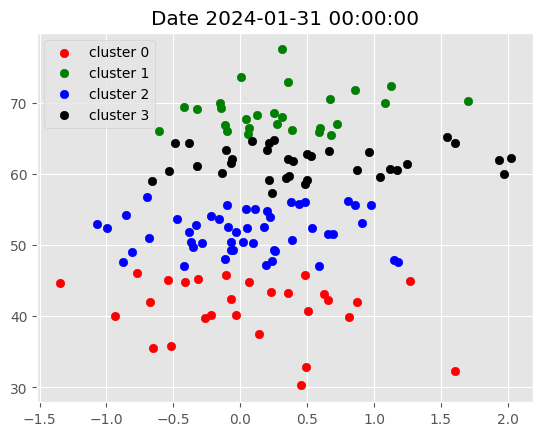

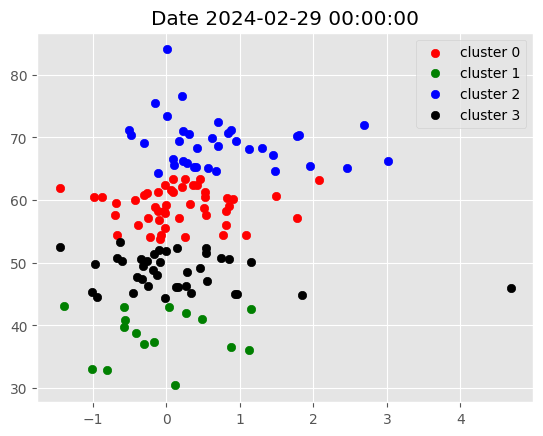

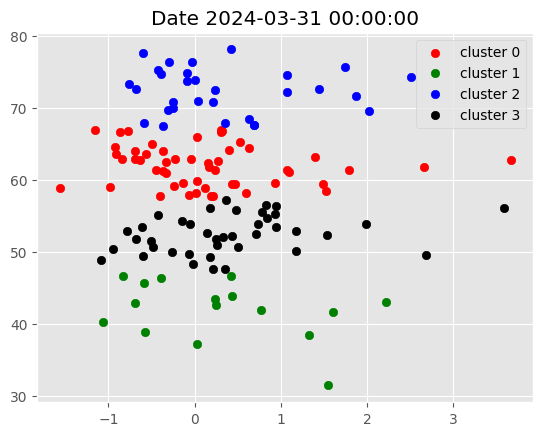

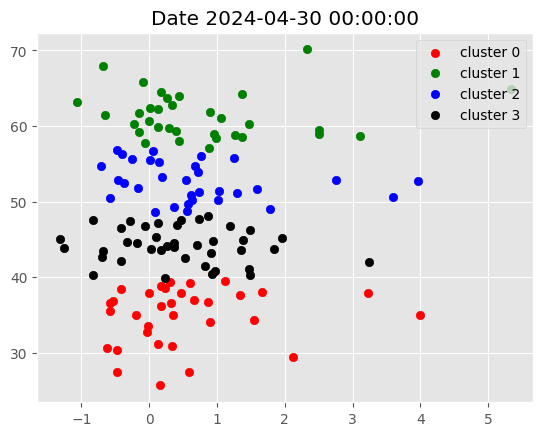

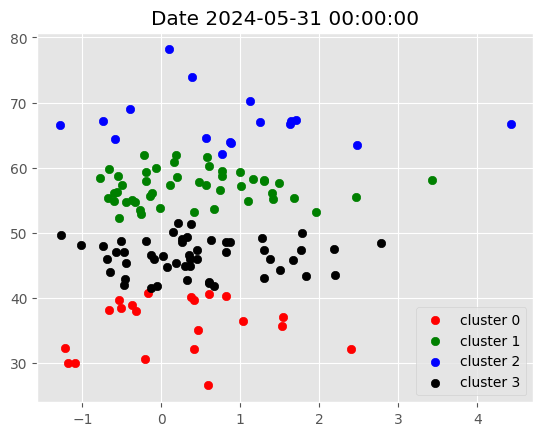

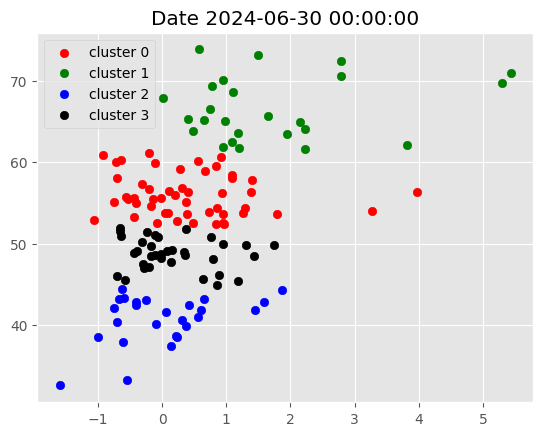

In [34]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [35]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [36]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-07-01': ['AAPL',
  'ADBE',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BIIB',
  'BMY',
  'CHTR',
  'CMCSA',
  'COP',
  'CSX',
  'CTSH',
  'CVX',
  'DG',
  'DIS',
  'ELV',
  'EXPE',
  'FCX',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'ISRG',
  'KO',
  'LLY',
  'LOW',
  'MA',
  'MDT',
  'META',
  'MO',
  'MRK',
  'MSFT',
  'ORLY',
  'OXY',
  'PANW',
  'PFE',
  'PM',
  'PYPL',
  'RTX',
  'TGT',
  'TMUS',
  'TSLA',
  'UNH',
  'UNP',
  'V',
  'WFC',
  'WMT',
  'XOM'],
 '2018-08-01': ['AAL',
  'ABBV',
  'ACN',
  'ADBE',
  'AVGO',
  'AXP',
  'BKNG',
  'CMG',
  'CRM',
  'CSCO',
  'CVS',
  'FCX',
  'GM',
  'MA',
  'MAR',
  'MCD',
  'MU',
  'NOC',
  'NVDA',
  'PANW',
  'PYPL',
  'SCHW',
  'TSLA',
  'TXN',
  'ULTA',
  'WYNN',
  'XOM'],
 '2018-09-01': ['ABT',
  'ACN',
  'ADBE',
  'AMGN',
  'AXP',
  'AZO',
  'BIIB',
  'BMY',
  'BRK-B',
  'CHTR',
  'CI',
  'CMCSA',
  'COP',
  'CRM',
  'CSX',
  'DD',
  'DG',
  'DHR',
  'ELV',
  'HD',
  'HON',
  'HUM',
  'JNJ',
  'KR',
  'LUV',
  'M

In [42]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [43]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838978   33.703407   53.369362   43.018215  111.341927   
2017-07-03  48.906925   33.581715   53.303120   43.106716  111.567001   
2017-07-05  49.751320   33.719780   53.347279   43.363350  111.675018   
2017-07-06  50.518066   33.401512   52.795254   42.425289  110.675766   
2017-07-07  51.469219   33.740845   53.016048   42.867771  111.819046   
...               ...         ...         ...         ...         ...   
2024-06-18  11.280000  214.289993  171.360001  103.989998  285.350006   
2024-06-20  11.240000  209.679993  172.130005  106.570000  306.160004   
2024-06-21  11.200000  207.490005  170.389999  105.720001  308.980011   
2024-06-24  11.160000  208.139999  172.740005  105.300003  307.209991   
2024-06-25  11.130000  209.070007  170.759995  105.489998  307.239990   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   68.014442   88.388855  100.820000  51.909603  ...   
2017-07-03  138.410004   66.536987   88.354332   99.360001  52.548927  ...   
2017-07-05  141.210007   67.961983   89.777756  102.599998  52.125477  ...   
2017-07-06  140.750000   67.603569   89.234283  102.050003  52.374561  ...   
2017-07-07  142.220001   68.600166   90.700798  103.320000  52.598743  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-18  522.250000  235.380005  244.410004  244.119995  74.129997  ...   
2024-06-20  522.950012  229.509995  246.059998  243.509995  74.879997  ...   
2024-06-21  533.440002  231.050003  247.970001  242.309998  74.889999  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-06-30   9036600  2972000  1582300  13368900   7097300  6614900  16750700   
2017-07-03   6197700  2160000   825200   9732000   2419200  4562300  11825000   
2017-07-05   9339600  3938100  1320600  14853400   6481000  5119800  14086900   
2017-07-06   8215700  3332100  1171800  16854300   6011600  4143800  14481200   
2017-07-07   6175800  5083600  1019900  12198500   6001900  3436800  11503500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-06-18   6707500  2552000  1230800  17125700  19148800  5463600  15547400   
2024-06-20  10164400  3204000  1409700  17704700  13146900  5902100  11985500   
2024-06-21  14790200  7128100  2825800  30390200  18512300  6825200  62733200   
2024-06-24  24149600  2851300  1188600  20773800  13632500  5122600  16198300   
2024-06-25   6918980  2873417  1142099  13881873  10109083  2664506  21349805   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-06-18  12093500  1604400  17762900  
2024-06-20  13860800  2039500  17433200  
2024-06-21  25891500  5340300  52220600  
2024-06-24  12470400  1828400  16266700  
2024-06-25  16962197  1427185   8881294  

[1757 rows x 936 columns]

In [44]:
new_df

Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838978   33.703407   53.369362   43.018215  111.341927   
2017-07-03  48.906925   33.581715   53.303120   43.106716  111.567001   
2017-07-05  49.751320   33.719780   53.347279   43.363350  111.675018   
2017-07-06  50.518066   33.401512   52.795254   42.425289  110.675766   
2017-07-07  51.469219   33.740845   53.016048   42.867771  111.819046   
...               ...         ...         ...         ...         ...   
2024-06-18  11.280000  214.289993  171.360001  103.989998  285.350006   
2024-06-20  11.240000  209.679993  172.130005  106.570000  306.160004   
2024-06-21  11.200000  207.490005  170.389999  105.720001  308.980011   
2024-06-24  11.160000  208.139999  172.740005  105.300003  307.209991   
2024-06-25  11.130000  209.070007  170.759995  105.489998  307.239990   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   68.014442   88.388855  100.820000  51.909603  ...   
2017-07-03  138.410004   66.536987   88.354332   99.360001  52.548927  ...   
2017-07-05  141.210007   67.961983   89.777756  102.599998  52.125477  ...   
2017-07-06  140.750000   67.603569   89.234283  102.050003  52.374561  ...   
2017-07-07  142.220001   68.600166   90.700798  103.320000  52.598743  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-18  522.250000  235.380005  244.410004  244.119995  74.129997  ...   
2024-06-20  522.950012  229.509995  246.059998  243.509995  74.879997  ...   
2024-06-21  533.440002  231.050003  247.970001  242.309998  74.889999  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2017-06-30   9036600  2972000  1582300  13368900   7097300  6614900  16750700   
2017-07-03   6197700  2160000   825200   9732000   2419200  4562300  11825000   
2017-07-05   9339600  3938100  1320600  14853400   6481000  5119800  14086900   
2017-07-06   8215700  3332100  1171800  16854300   6011600  4143800  14481200   
2017-07-07   6175800  5083600  1019900  12198500   6001900  3436800  11503500   
...              ...      ...      ...       ...       ...      ...       ...   
2024-06-18   6707500  2552000  1230800  17125700  19148800  5463600  15547400   
2024-06-20  10164400  3204000  1409700  17704700  13146900  5902100  11985500   
2024-06-21  14790200  7128100  2825800  30390200  18512300  6825200  62733200   
2024-06-24  24149600  2851300  1188600  20773800  13632500  5122600  16198300   
2024-06-25   6918980  2873417  1142099  13881873  10109083  2664506  21349805   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-06-18  12093500  1604400  17762900  
2024-06-20  13860800  2039500  17433200  
2024-06-21  25891500  5340300  52220600  
2024-06-24  12470400  1828400  16266700  
2024-06-25  16962197  1427185   8881294  

[1757 rows x 936 columns]

In [45]:
new_df.columns

MultiIndex([('Adj Close',  'AAL'),
            ('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ('Adj Close',  'ADP'),
            ('Adj Close', 'ADSK'),
            ('Adj Close',  'AIG'),
            ...
            (   'Volume',    'V'),
            (   'Volume',  'VLO'),
            (   'Volume', 'VRTX'),
            (   'Volume',   'VZ'),
            (   'Volume',  'WBA'),
            (   'Volume',  'WDC'),
            (   'Volume',  'WFC'),
            (   'Volume',  'WMT'),
            (   'Volume', 'WYNN'),
            (   'Volume',  'XOM')],
           names=['Price', 'Ticker'], length=936)

In [46]:
import numpy as np
import pandas as pd

# Calculate log returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
            weights = pd.DataFrame(weights, index=optimization_df.columns, columns=['weight'])
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns, columns=['weight'])

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights, left_index=True, right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the

""


In [47]:
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

# Calculate log returns
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
            weights = pd.Series(weights, name='weight')
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
            print(f'Error: {str(e)}')

        if not success:
            weights = pd.Series([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                index=optimization_df.columns, name='weight')

        temp_df = returns_dataframe[start_date:end_date][cols]

        temp_df = temp_df.stack().to_frame('return').reset_index()
        temp_df.columns = ['Date', 'ticker', 'return']

        temp_df = temp_df.merge(weights.reset_index(), left_on='ticker', right_on='index', how='left')
        temp_df = temp_df.set_index(['Date', 'ticker'])

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(f"Error processing {start_date}: {str(e)}")

portfolio_df = portfolio_df.drop_duplicates()

print(portfolio_df)

Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2018-12-01: 'index'
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2019-01-01: 'index'
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2019-07-01: 'index'
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Weights
Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2019-09-01: 'index'
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Error: ('Please check your objectiv

In [48]:
portfolio_df

,Strategy Return
Date,
2018-07-02,0.001420
2018-07-03,-0.001350
2018-07-05,0.004951
2018-07-06,0.011834
2018-07-09,0.009452
...,...
2024-06-18,-0.000996
2024-06-20,0.002516
2024-06-21,-0.002219


In [49]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2018-07-02,0.001420,0.002136
2018-07-03,-0.001350,-0.003537
2018-07-05,0.004951,0.008125
2018-07-06,0.011834,0.008423
2018-07-09,0.009452,0.008964
...,...,...
2024-06-17,0.008531,0.007927
2024-06-18,-0.000996,0.002538
2024-06-20,0.002516,-0.002720


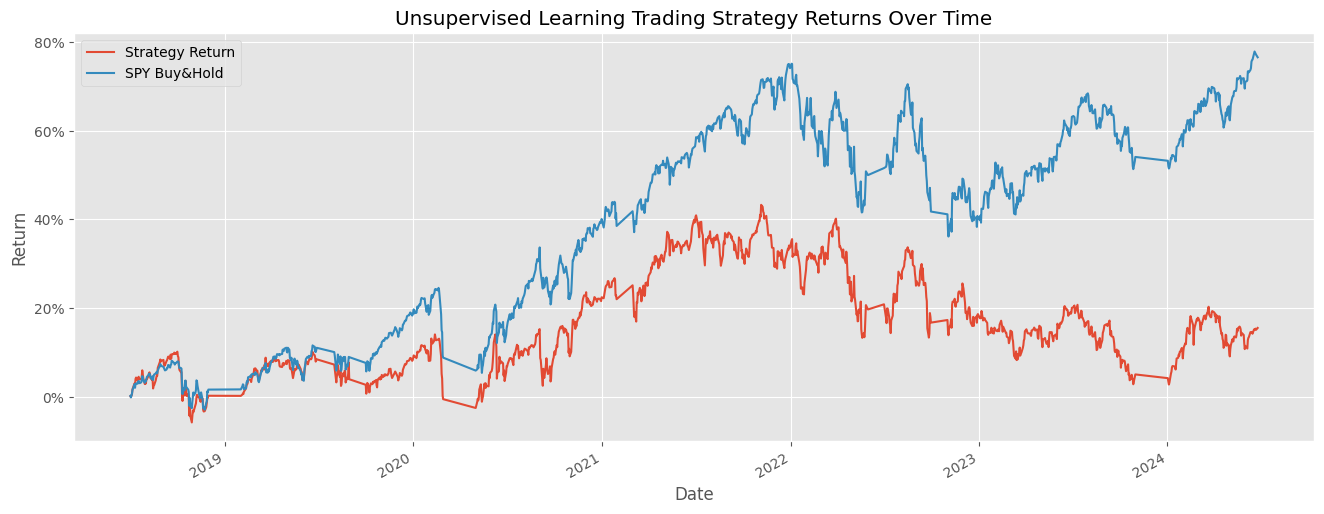

In [51]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-24'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [54]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

In [60]:
sentiment_df = pd.read_csv('sentiment_data.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [61]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [62]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

In [63]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [64]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  85 of 85 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [65]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,


In [66]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
